In [2]:
import bagpy
import folium
import pandas as pd
from bagpy import bagreader
from geopy.distance import geodesic
from IPython.display import HTML, display
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import utm
import seaborn as sns
%matplotlib notebook
pd.set_option("display.precision", 12)
#
# Author: Nathaniel Hanson
# Date: 02/16/2021
# Purpose: Straight line path GPS analysis
#

In [11]:
line = bagreader('./record-line_2021-02-18-14-04-35.bag')
print(line.topic_table)
dataStat = pd.read_csv(line.message_by_topic('/gps_data'))

[INFO]  Data folder ./record-line_2021-02-18-14-04-35 already exists. Not creating.
      Topics            Types  Message Count       Frequency
0  /gps_data   gps_driver/GPS             97  3.271804108492
1  /raw_data  std_msgs/String            347  9.883240591396


In [12]:
dataStat

Time  header.seq  header.stamp.secs  header.stamp.nsecs  \
0   1.613675087549e+09           1         1613675087           545440912   
1   1.613675087869e+09           2         1613675087           857404947   
2   1.613675088170e+09           3         1613675088           160969972   
3   1.613675088780e+09           4         1613675088           768125057   
4   1.613675089080e+09           5         1613675089            70815086   
..                 ...         ...                ...                 ...   
92  1.613675121009e+09          93         1613675120           997446060   
93  1.613675121611e+09          94         1613675121           602977991   
94  1.613675121917e+09          95         1613675121           907871007   
95  1.613675122220e+09          96         1613675122           211214065   
96  1.613675122530e+09          97         1613675122           518436908   

    header.frame_id              lat              lon        altitude  \
0                 1  42.352413177490 -71.077102661133 -2.400000095367   
1                 1  42.352405548096 -71.077110290527 -2.200000047684   
2                 1  42.352401733398 -71.077110290527 -2.000000000000   
3                 1  42.352397918701 -71.077117919922 -2.099999904633   
4                 1  42.352394104004 -71.077133178711 -2.200000047684   
..              ...              ...              ...             ...   
92                1  42.351856231689 -71.078399658203 -0.400000005960   
93                1  42.351852416992 -71.078414916992 -0.300000011921   
94                1  42.351852416992 -71.078430175781 -0.200000002980   
95                1  42.351848602295 -71.078445434570 -0.300000011921   
96                1  42.351848602295 -71.078453063965 -0.200000002980   

     utm_easting  utm_northing  num_sats            hdop  zone letter  
0   328928.12500     4690995.0         5  3.700000047684    19      T  
1   328927.84375     4690994.0         5  3.700000047684    19      T  
2   328927.28125     4690993.5         5  3.700000047684    19      T  
3   328926.59375     4690993.5         5  3.700000047684    19      T  
4   328925.75000     4690993.0         5  3.700000047684    19      T  
..           ...           ...       ...             ...   ...    ...  
92  328820.09375     4690935.5         5  3.599999904633    19      T  
93  328818.84375     4690935.5         5  3.599999904633    19      T  
94  328817.62500     4690935.5         5  3.599999904633    19      T  
95  328816.37500     4690935.0         5  3.599999904633    19      T  
96  328815.12500     4690935.0         5  3.599999904633    19      T  

[97 rows x 14 columns]

In [9]:
# Plot locations on a map
m = folium.Map(
    location=[42.351944, -71.077415],
    max_zoom=20,
    zoom_start=19
)
temp = dataStat.apply(lambda row:folium.CircleMarker(location=[row["lat"], 
                                                  row["lon"]]).add_to(m),
         axis=1)
# Plot straight line from start path to end path
start = [42.352257, -71.076889]
end = dataStat.tail(1)[['lat', 'lon']].values[0]
# Interpolate a straight line
latInterp = np.linspace(start[0], end[0], len(dataStat))
lonInterp = np.linspace(start[1], end[1], len(dataStat))
joinInterp = list(zip(latInterp, lonInterp))
temp = [folium.CircleMarker(location=loc, color='red').add_to(m) for loc in joinInterp] 
display(m)

In [13]:
# Convert truth points to utm
utmInterp = [utm.from_latlon(*point)[0:2] for point in joinInterp]
# Add points to dataframe
dataStat['truth_east'] = [z[0] for z in utmInterp]
dataStat['truth_north'] = [z[1] for z in utmInterp]

In [14]:
# Calculate distance from true location to all points
# https://en-us.topographic-map.com/maps/f02f/Boston/
true_alt = 6.7056 # meters
true_utm = [328901.81, 4690968.93, true_alt]
dataStat['error_abs'] = dataStat.apply(
    lambda row: np.sqrt(
        (row['utm_easting']-row['truth_east'])**2 + 
        (row['utm_northing']-row['truth_north'])**2),
    axis = 1)
dataStat['error_east'] = dataStat.apply(
    lambda row: np.sqrt(
        (row['utm_easting']-row['truth_east'])**2),
    axis = 1)
dataStat['error_north'] = dataStat.apply(
    lambda row: np.sqrt(
        (row['utm_northing']-row['truth_north'])**2),
    axis = 1)
dataStat['error_alt'] = dataStat.apply(
    lambda row: np.sqrt(
        (row['utm_northing']-row['truth_north'])**2),
    axis = 1)
dataStat['time_elapsed'] =dataStat.apply(
    lambda row: row['header.stamp.secs'] - dataStat.min()['header.stamp.secs'],
    axis = 1
)

<IPython.core.display.Javascript object>


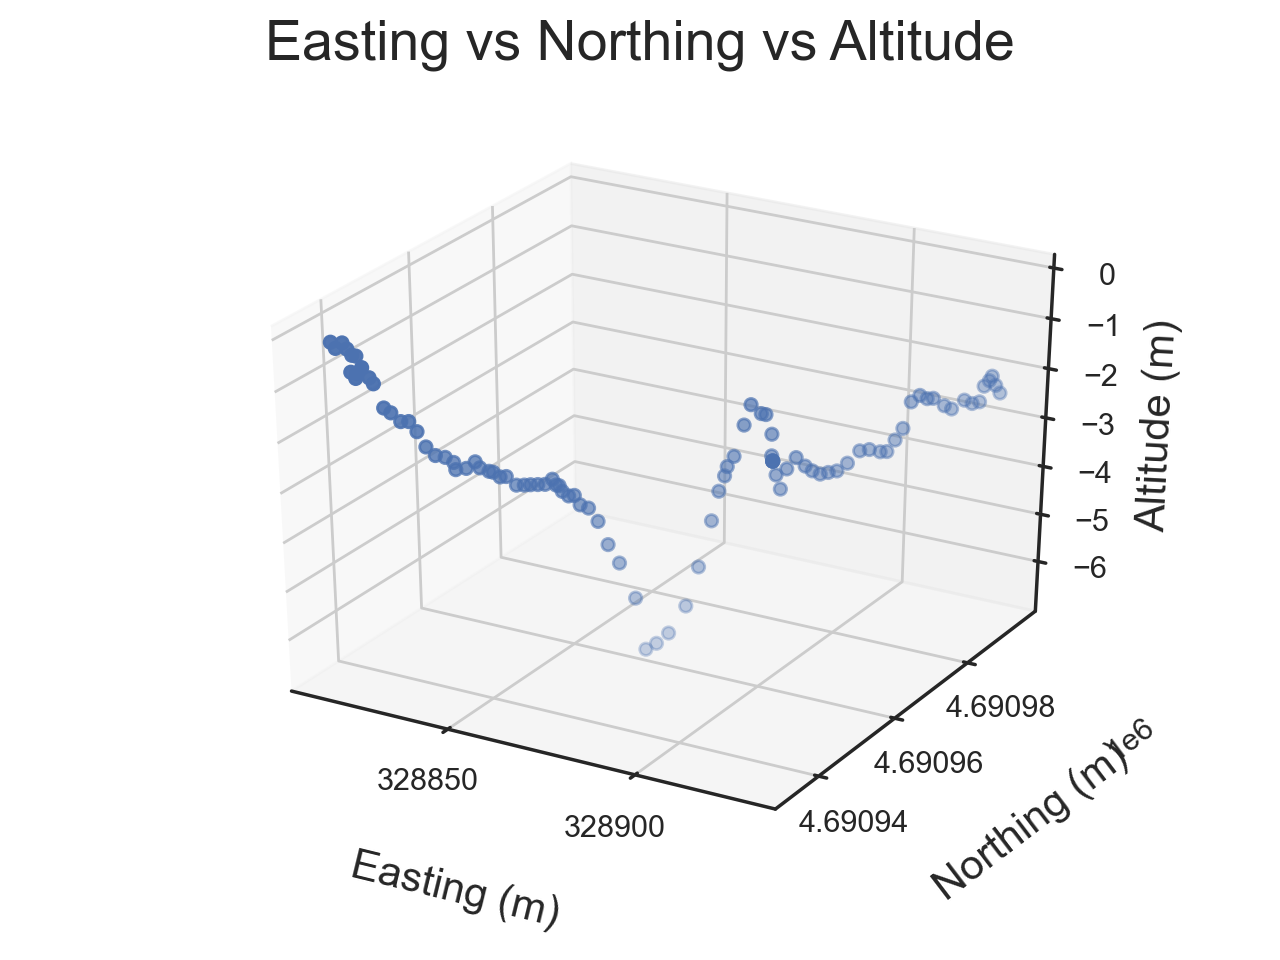

<IPython.core.display.Javascript object>


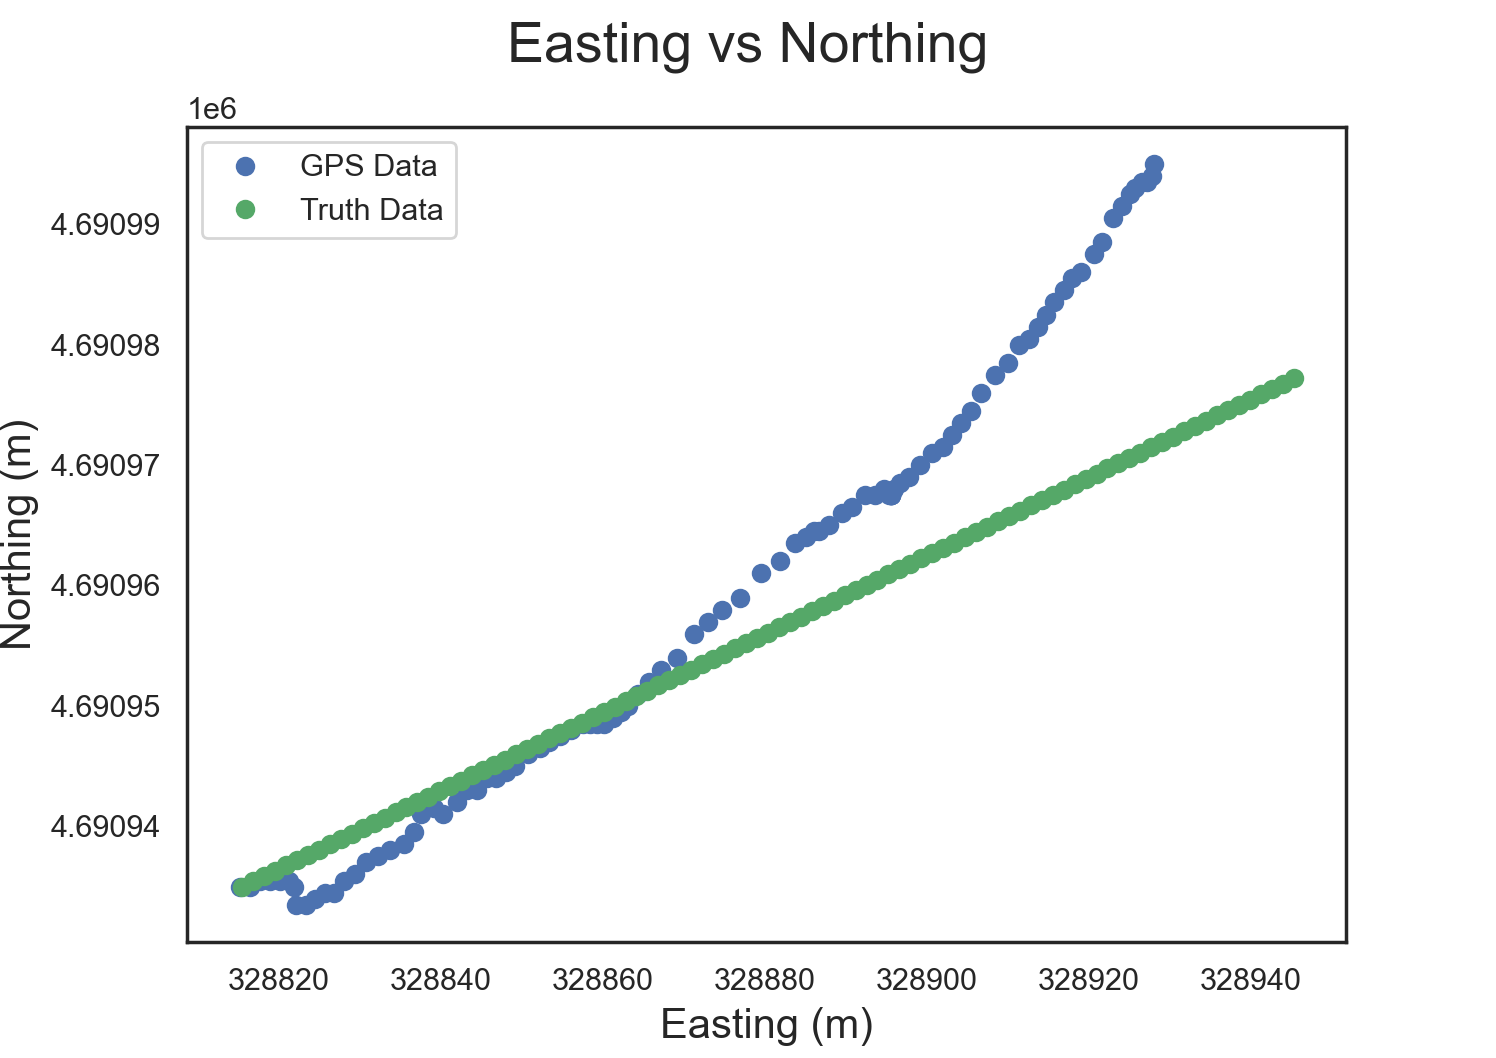

In [37]:
# Plot the surface.
fig = plt.figure()
ax = fig.gca(projection='3d')

# Surface plot data
x = dataStat['utm_easting']
y = dataStat['utm_northing']
z = dataStat['altitude']

surf = ax.scatter(x,y,z)
# title and labels, setting initial sizes
fig.suptitle('Easting vs Northing vs Altitude', fontsize=20)
ax.set_xlabel('Easting (m)', fontsize=15, labelpad = 20)
ax.set_ylabel('Northing (m)', fontsize=15, labelpad = 20)   # relative to plt.rcParams['font.size']
ax.set_zlabel('Altitude (m)', fontsize=15)   # relative to plt.rcParams['font.size']
ax.ticklabel_format(useOffset=False)
plt.locator_params(axis="y", nbins=4)
plt.locator_params(axis="x", nbins=4)

# Location over time
fig2 = plt.figure()
ax2 = fig2.gca()
plt.plot(dataStat['utm_easting'], dataStat['utm_northing'], 'bo', label='GPS Data')
plt.plot(dataStat['truth_east'], dataStat['truth_north'], 'go', label='Truth Data')
fig2.suptitle('Easting vs Northing', fontsize=20)
ax2.set_xlabel('Easting (m)', fontsize=15)
ax2.set_ylabel('Northing (m)', fontsize=15)   # relative to plt.rcParams['font.size']
ax2.ticklabel_format(useOffset=False)
ax2.legend()

<IPython.core.display.Javascript object>


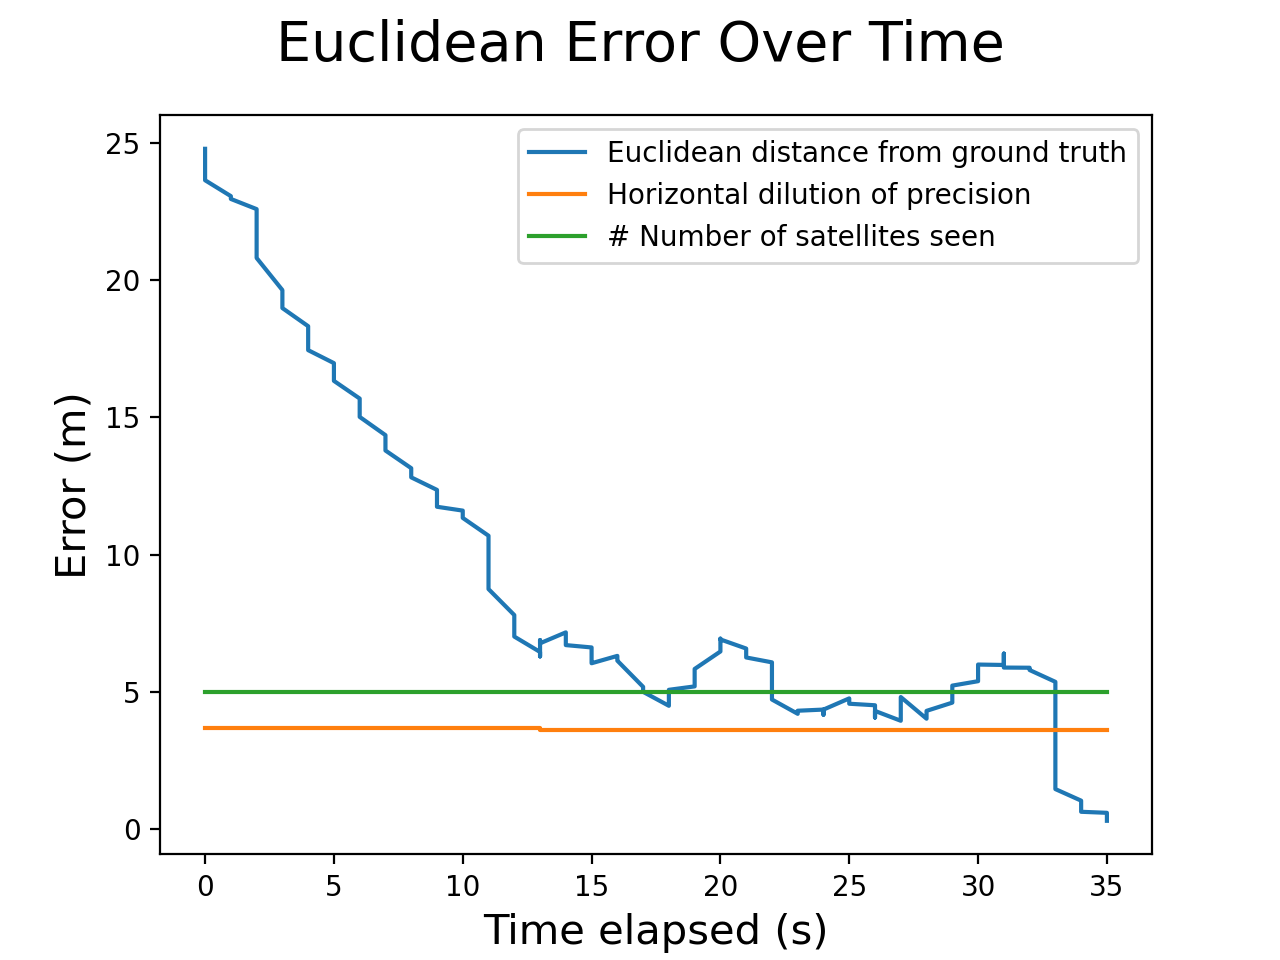

In [18]:
### Error plots
# Absolute error over time
fig3 = plt.figure()
ax3 = fig3.gca()
plt.plot(dataStat['time_elapsed'], dataStat['error_abs'], label='Euclidean distance from ground truth')
plt.plot(dataStat['time_elapsed'], dataStat['hdop'], label='Horizontal dilution of precision')
plt.plot(dataStat['time_elapsed'], dataStat['num_sats'], label='# Number of satellites seen')
fig3.suptitle('Euclidean Error Over Time', fontsize=20)
ax3.set_xlabel('Time elapsed (s)', fontsize=15)
ax3.set_ylabel('Error (m)', fontsize=15)   # relative to plt.rcParams['font.size']
ax3.ticklabel_format(useOffset=False)
ax3.legend()

<IPython.core.display.Javascript object>


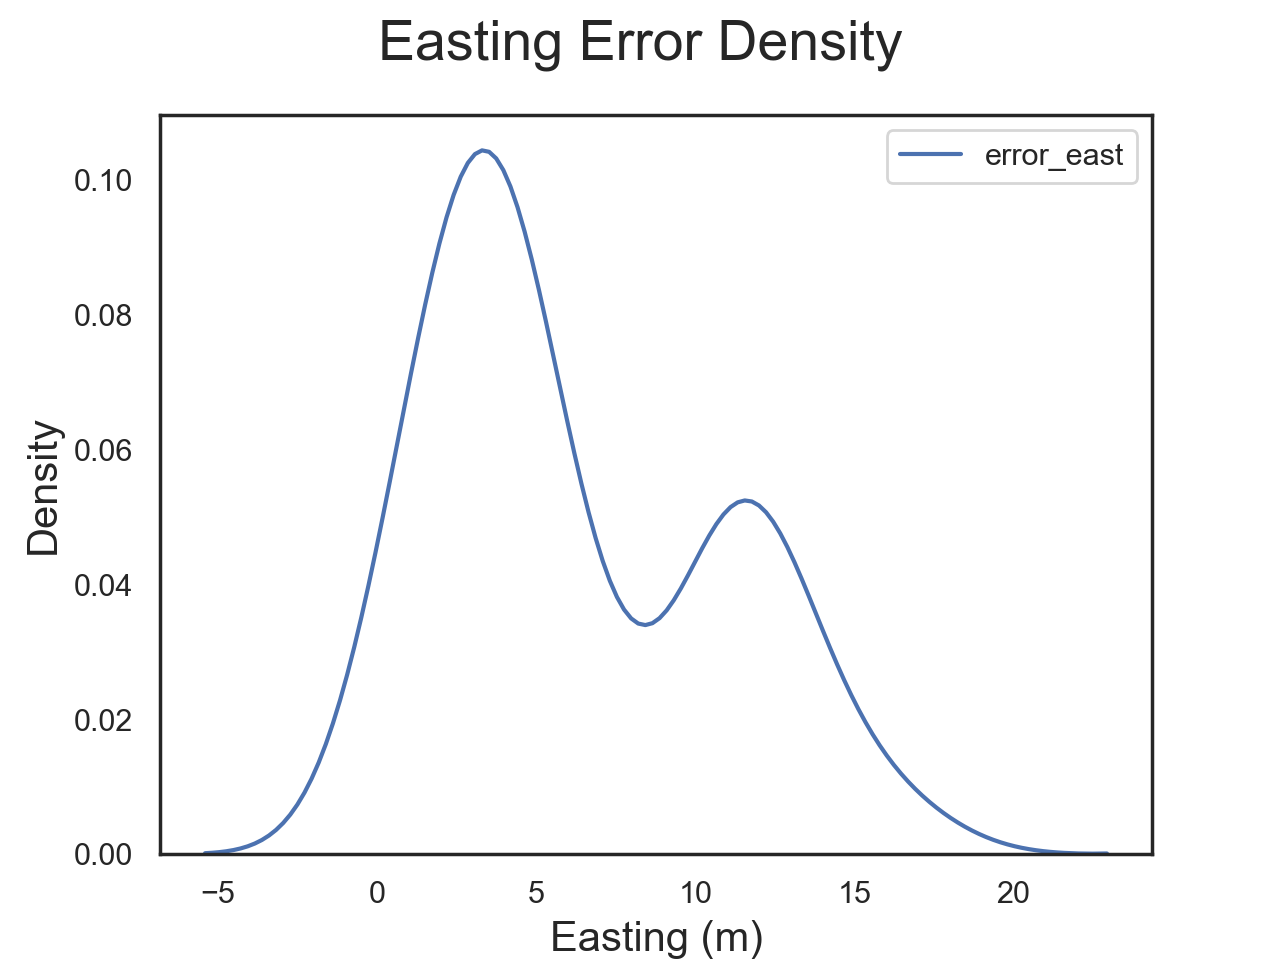

<IPython.core.display.Javascript object>


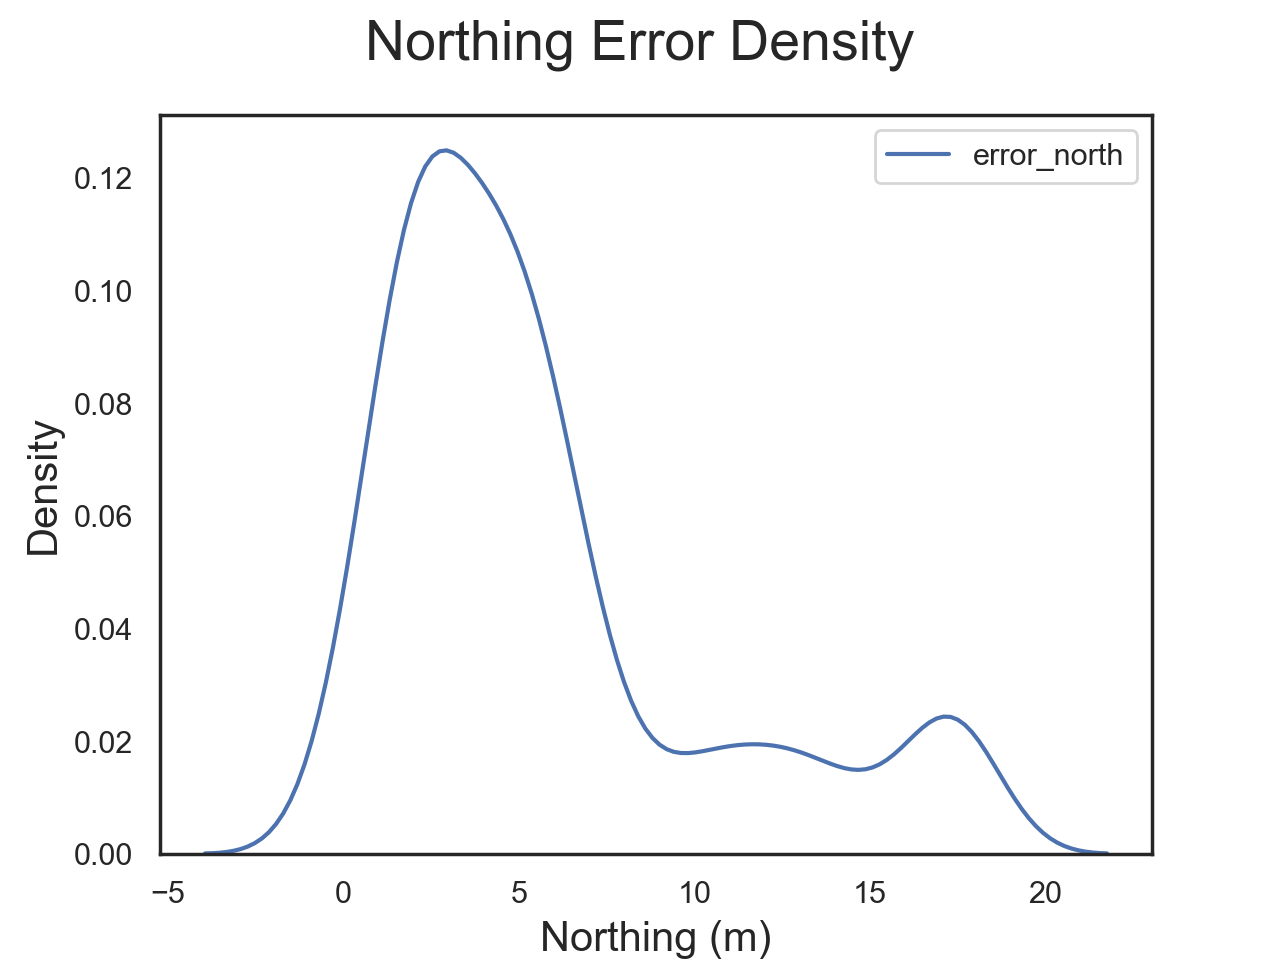

<IPython.core.display.Javascript object>


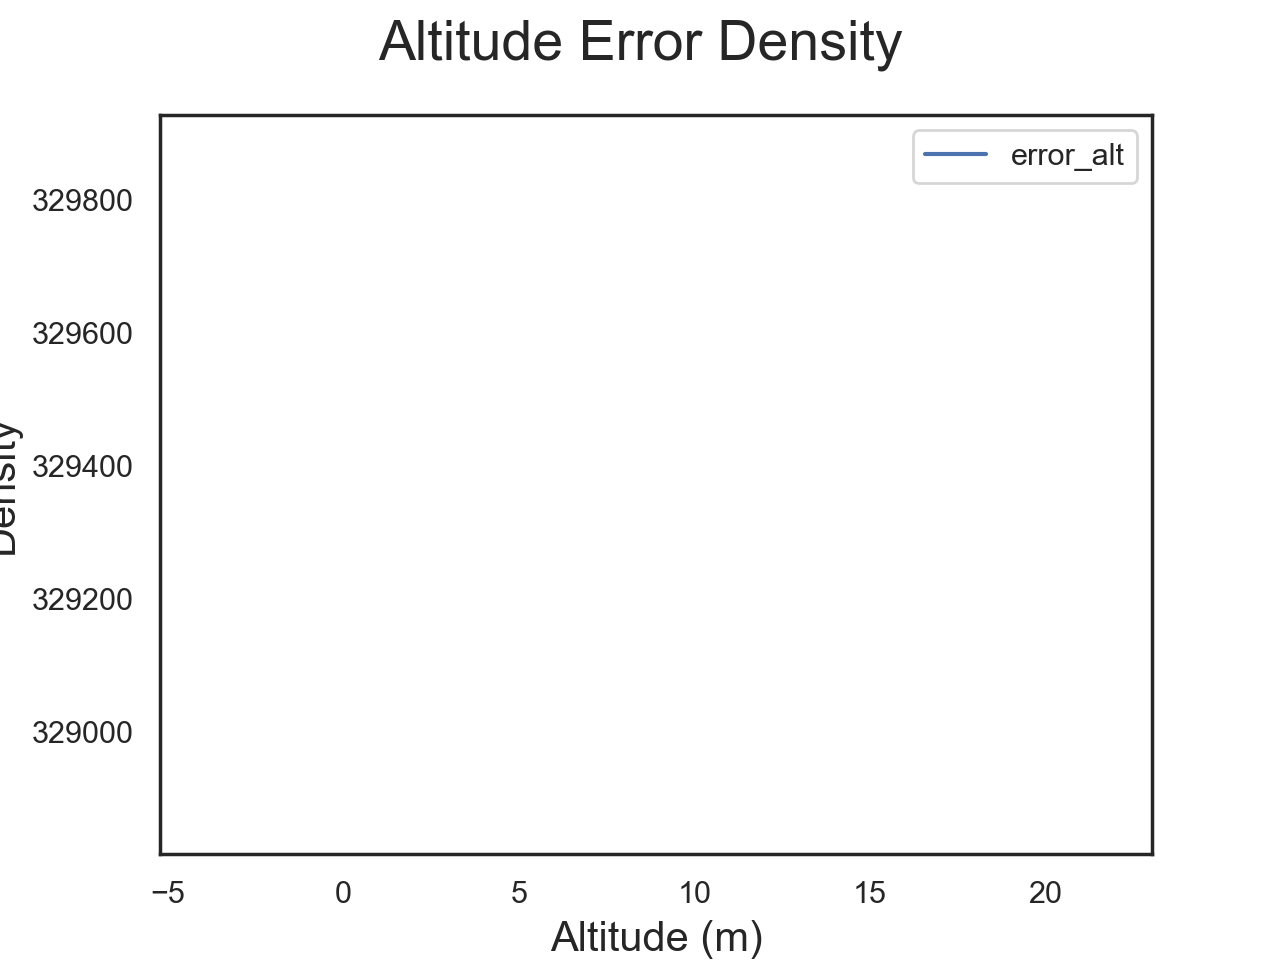

Text(0, 0.5, 'Density')

In [52]:
# Distribution of locations
# Location over time - we would expect this to be a uniform distribution
# Easting
fig2 = plt.figure()
ax2 = fig2.gca()
sns.kdeplot(dataStat['error_east'])
fig2.suptitle('Easting Error Density', fontsize=20)
ax2.set_xlabel('Easting (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15)
# Northing
fig2 = plt.figure()
ax2 = fig2.gca()
sns.kdeplot(dataStat['error_north'])
fig2.suptitle('Northing Error Density', fontsize=20)
ax2.set_xlabel('Northing (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15)
# Altitude
fig2 = plt.figure()
ax2 = fig2.gca()
sns.kdeplot(dataStat['error_alt'])
fig2.suptitle('Altitude Error Density', fontsize=20)
ax2.set_xlabel('Altitude (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15)

<IPython.core.display.Javascript object>


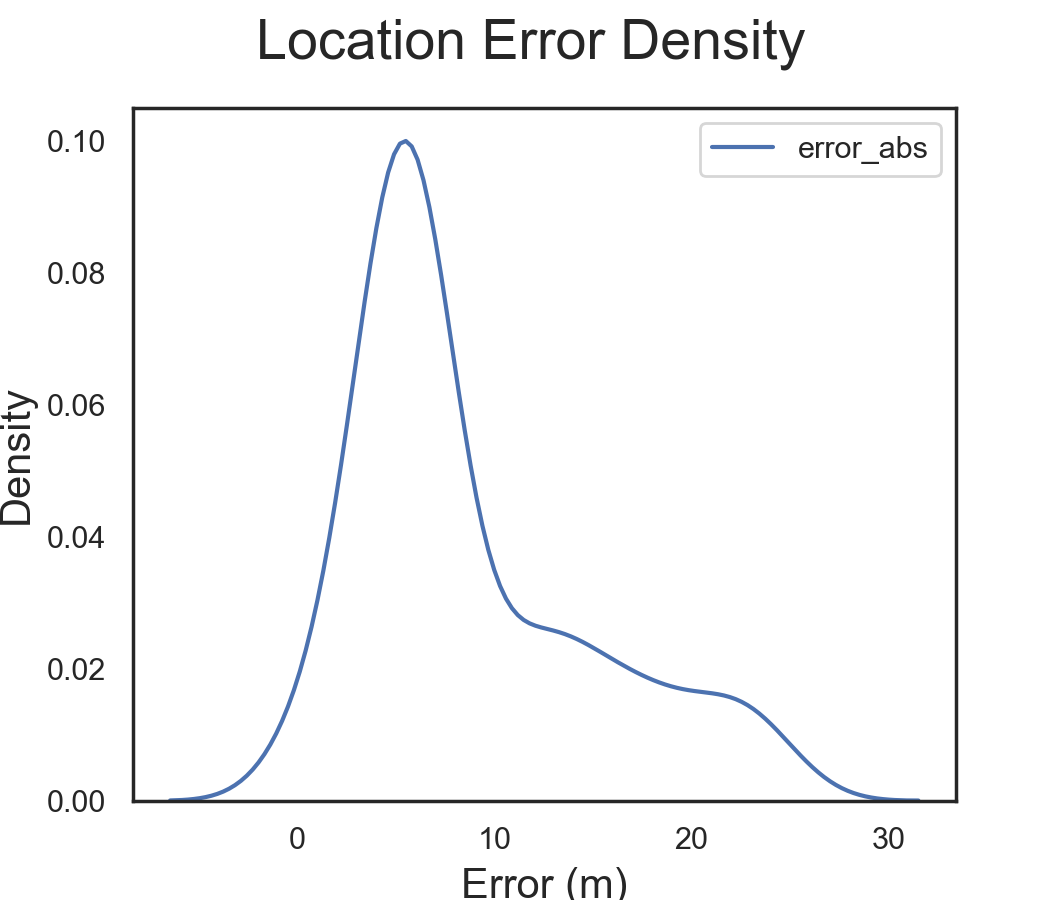

Text(0, 0.5, 'Density')

In [49]:
# Absolute Error
fig2 = plt.figure()
ax2 = fig2.gca()
sns.kdeplot(dataStat['error_abs'])
fig2.suptitle('Location Error Density', fontsize=20)
ax2.set_xlabel('Error (m)', fontsize=15)
ax2.set_ylabel('Density', fontsize=15) 

<IPython.core.display.Javascript object>


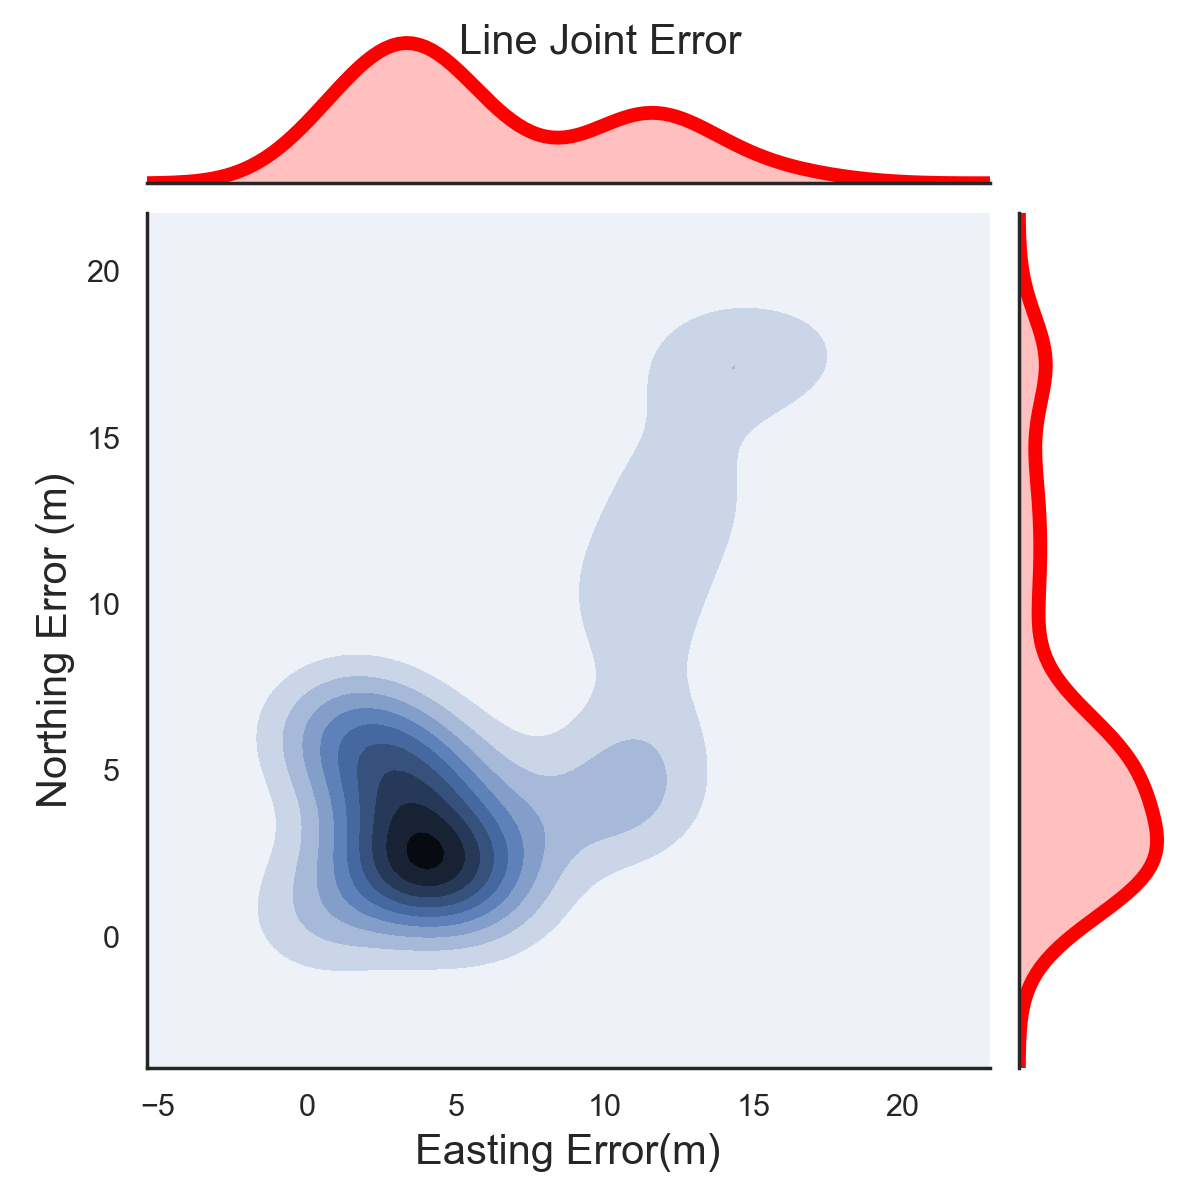

In [62]:
# 2 dimensional KDE
sns.set(style="white", color_codes=True)
plt.ylim(dataStat['utm_easting'].min(), dataStat['utm_easting'].max() + 1000)
ax = sns.jointplot(
    x=dataStat["error_east"],
    y=dataStat["error_north"],
    kind='kde',
    marginal_kws={'lw':5,
                 'color':'red'})
ax.fig.suptitle('Line Joint Error', fontsize=15)
ax.set_axis_labels('Easting Error(m)', 'Northing Error (m)', fontsize=15)

In [55]:
# Print summary statistics
pd.set_option("display.width", 250)
d = dataStat.describe()[['error_abs', 'error_east', 'error_north']]
d.columns = ['Error Euclidean (m)', 'Easting Error (m)', 'Northing Error (m)']
d

Error Euclidean (m)  Easting Error (m)  Northing Error (m)
count      97.000000000000    97.000000000000     97.000000000000
mean        8.771154623812     6.209794531006      5.692846525124
std         6.061191293550     4.476031578898      4.767431239647
min         0.303363218199     0.303292696772      0.006540813483
25%         4.762284650395     3.171982106636      2.345566391014
50%         6.253023655401     4.041910956614      4.372757242993
75%        11.912098749933    10.951739273267      6.537157249637
max        24.780791996613    17.235221365932     17.805470969528

In [19]:
dataStat.describe()

Time       header.seq   header.stamp.secs  \
count  9.700000000000e+01  97.000000000000  9.700000000000e+01   
mean   1.613675105073e+09  49.000000000000  1.613675104557e+09   
std    1.026995875259e+01  28.145455524235  1.027230203038e+01   
min    1.613675087549e+09   1.000000000000  1.613675087000e+09   
25%    1.613675096377e+09  25.000000000000  1.613675096000e+09   
50%    1.613675105191e+09  49.000000000000  1.613675105000e+09   
75%    1.613675113710e+09  73.000000000000  1.613675113000e+09   
max    1.613675122530e+09  97.000000000000  1.613675122000e+09   

       header.stamp.nsecs  header.frame_id              lat              lon  \
count  9.700000000000e+01             97.0  97.000000000000  97.000000000000   
mean   5.065200643608e+08              1.0  42.352081534789 -71.077747226990   
std    2.906473175567e+08              0.0   0.000175411978   0.000413053090   
min    6.877899000000e+06              1.0  42.351837158203 -71.078453063965   
25%    2.584750650000e+08              1.0  42.351928710938 -71.078102111816   
50%    5.184369080000e+08              1.0  42.352077484131 -71.077713012695   
75%    7.548620700000e+08              1.0  42.352195739746 -71.077415466309   
max    9.974460600000e+08              1.0  42.352413177490 -71.077102661133   

              altitude          utm_easting        utm_northing  num_sats  \
count  97.000000000000      97.000000000000  9.700000000000e+01      97.0   
mean   -2.670103099850  328874.184600515466  4.690959427835e+06       5.0   
std     1.266899514063      34.478422803947  1.864093134223e+01       0.0   
min    -6.599999904633  328815.125000000000  4.690933500000e+06       5.0   
25%    -3.099999904633  328844.437500000000  4.690943000000e+06       5.0   
50%    -2.799999952316  328876.968750000000  4.690959000000e+06       5.0   
75%    -2.200000047684  328902.000000000000  4.690971500000e+06       5.0   
max    -0.200000002980  328928.125000000000  4.690995000000e+06       5.0   

                  hdop  zone           truth_east         truth_north  \
count  97.000000000000  97.0      97.000000000000  9.700000000000e+01   
mean    3.637113359786  19.0  328880.394395046576  4.690956093799e+06   
std     0.048561859207   0.0      38.093680411902  1.237258681609e+01   
min     3.599999904633  19.0  328815.428292696772  4.690934993459e+06   
25%     3.599999904633  19.0  328847.911431764718  4.690945543505e+06   
50%     3.599999904633  19.0  328880.394466232217  4.690956093698e+06   
75%     3.700000047684  19.0  328912.877396099328  4.690966644040e+06   
max     3.700000047684  19.0  328945.360221365932  4.690977194529e+06   

             error_abs       error_east      error_north        error_alt  \
count  97.000000000000  97.000000000000  97.000000000000  97.000000000000   
mean    8.771154623812   6.209794531006   5.692846525124   5.692846525124   
std     6.061191293550   4.476031578898   4.767431239647   4.767431239647   
min     0.303363218199   0.303292696772   0.006540813483   0.006540813483   
25%     4.762284650395   3.171982106636   2.345566391014   2.345566391014   
50%     6.253023655401   4.041910956614   4.372757242993   4.372757242993   
75%    11.912098749933  10.951739273267   6.537157249637   6.537157249637   
max    24.780791996613  17.235221365932  17.805470969528  17.805470969528   

          time_elapsed  
count  97.000000000000  
mean   17.556701030928  
std    10.272302030384  
min     0.000000000000  
25%     9.000000000000  
50%    18.000000000000  
75%    26.000000000000  
max    35.000000000000